# DSCI100 Final Project Report 

###  By Pouya Khoshnavazi, Tom Shi, Ege Taslicay, Rudra Patel

## Section 1 - Introduction

We will begin by loading in the libraries we need for our wrangling and predictions.

In [14]:
library(tidyverse) 
library(repr)
library(lubridate)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(hms)

**Background Information:**

This project report uses 2 datasets extracted from the Plaicraft project at UBC. We have one data set with information about players which are observations and another with information about play sessions. 

PlaiCraft is a minecraft server setup by UBC to gather data on human play sessions. 

We will use these 2 datasets to make a prediction that will help us answer our predictive question.


**Question:**

Our specific question would be whether a player's age and experience level can accurately predict a player's total played hours using knn-regression to obtain players that contribute the largest amount of data.

**Data Description**

The data for this project consists of two files: one for player data and one for session data.

**Players File (players.csv):**
- **Number of observations / Rows**: 196
- **Number of variables / Columns**: 9
- **Variables**:
  - **experience**: Categorical, indicating player’s experience level (e.g., Beginner, Pro).
  - **subscribe**: Categorical, indicating email subscription status.
  - **hashedEmail**: Unique hashed identifier for each players email.
  - **played_hours**: Numerical, total hours played.
  - **name**: Player’s name.
  - **gender**: Categorical (e.g., Male, Female) players gender.
  - **age**: Numeric, player’s age.
  - **individualId**: Empty column.
  - **organizationName**: Empty column.

**Sessions File (sessions.csv):**
- **Number of observations / Rows**: 1,535
- **Number of variables / Columns**: 5
- **Variables**:
  - **hashedEmail**: Hashed identifier linking to players.
  - **start_time**: Date, session start time.
  - **end_time**: Date, session end time.
  - **original_start_time**: Unix timestamp for session start.
  - **original_end_time**: Unix timestamp for session end.

**Potential Issues**:
- **Missing data**: Some cells may be empty; `individualId` and `organizationName` are empty.
- **Unix Time**: May need conversion for better usability or removal since redundant.


## Section 2 - Methods and results

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 3 rows [106, 1221, 1222].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 4 rows [52, 1063, 1066,
1238].”


hashedEmail,start_date,start_time_only,end_date,end_time_only
<chr>,<chr>,<chr>,<chr>,<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30,18:12:00,2024-06-30,18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17,23:33:00,2024-06-17,23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25,17:34:00,2024-07-25,17:57:00
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28,15:36:00,2024-07-28,15:57:00
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25,06:15:00,2024-07-25,06:22:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20,02:26:00,2024-05-20,02:45:00


hashedEmail,played_hours,name,gender,age,experience,experience_num
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,Pro,4
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,Veteran,5
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,Veteran,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮
d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,Amateur,2
f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,Amateur,2
d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,Pro,4


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


experience,mean_played_hours
<chr>,<dbl>
Amateur,7.8622222
Beginner,1.4740741
Pro,0.5000000
Regular,1.6142857
Veteran,0.7414634


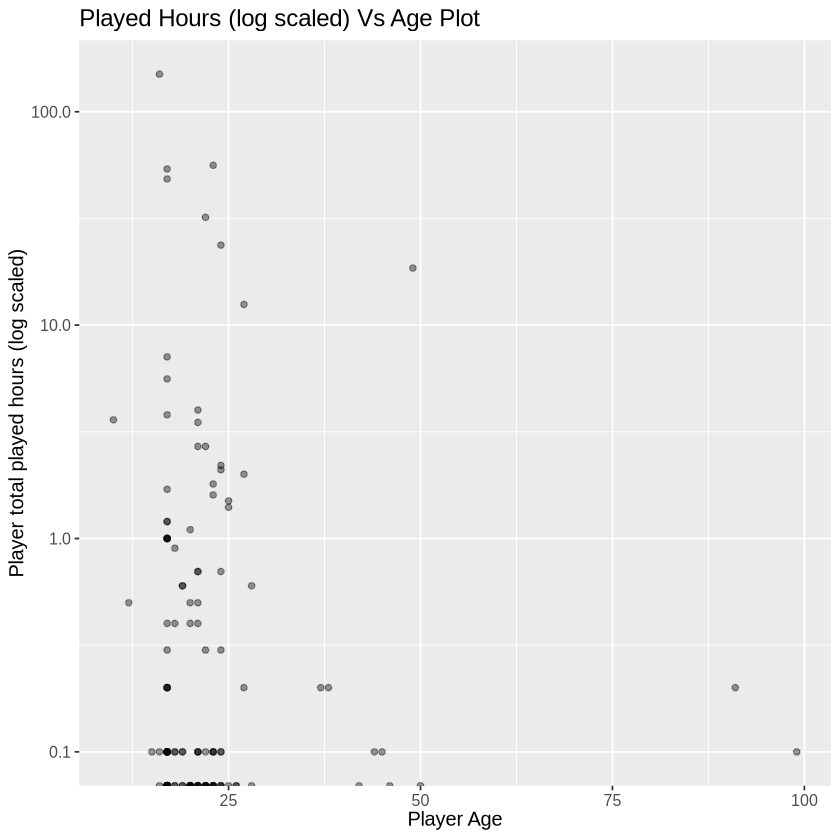

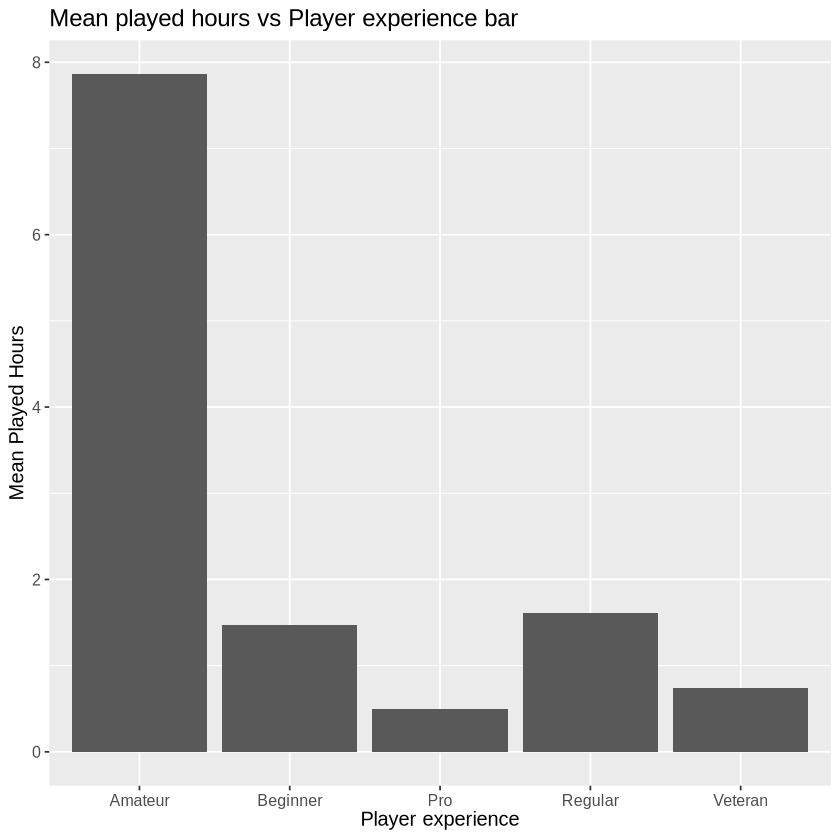

In [24]:
set.seed(2020)

# Reading data into R from given link.

player_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")

session_data <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")


# cleaned data by only including non empty columns 

player_data <- player_data |>
          select(hashedEmail, played_hours,	name, gender, age, experience) |>
          mutate(experience_num = case_when(experience == "Beginner" ~ 1,
                                  experience == "Amateur" ~ 2,
                                  experience == "Regular" ~ 3, 
                                  experience == "Pro" ~ 4, 
                                  experience == "Veteran" ~ 5))
    


# seperated date and time into two seperate columns since you can only have one value in a single cell
# removed original_start_time and original_end_time since they are in unix time arent very useful as we already have start_time and end_time and 
# do not provide valuable session length data since subtracting them gives 0 in most cases 

session_data <- session_data |>
  mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time)) |>
  separate(start_time, into = c("start_date", "start_time_only"), sep = " ", convert = TRUE) |>
  separate(end_time, into = c("end_date", "end_time_only"), sep = " ", convert = TRUE) |>
  select(hashedEmail, start_date, start_time_only, end_date, end_time_only)

session_data

player_data


player_split <- initial_split(player_data, prop = 0.75, strata = played_hours)
player_train <- training(player_split)
player_test <- testing(player_split)

       
played_hours_vs_age_plot <- player_train |>
                        ggplot(aes(x=age, y=played_hours)) +
                        geom_point(alpha=0.4) +
                        labs(x="Player Age", y= "Player total played hours (log scaled)") +
                        ggtitle("Played Hours (log scaled) Vs Age Plot") +
                        theme(text = element_text(size = 12)) +
                        scale_y_log10()

played_hours_vs_age_plot 



mean_played_hours_and_experience <- group_by(player_train, experience) |>
                                    summarize(mean_played_hours = mean(played_hours))
                            
mean_played_hours_and_experience


mean_played_hours_vs_experience_bar <- ggplot(mean_played_hours_and_experience, aes(x=experience, y= mean_played_hours)) +
                    		geom_bar(stat= "identity") +
                            labs(x = "Player experience",
                               y = "Mean Played Hours",
                              title = "Mean played hours vs Player experience bar") +
                              theme(text = element_text(size = 12))
mean_played_hours_vs_experience_bar                        


In [25]:
# start with 0 or 1, whatever you want. also check me on amateur being the bottom lol

#likely K value will be 55

player_train


player_recipe <- recipe(played_hours ~ age + experience_num, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                              set_engine("kknn") |>
                              set_mode("regression")

player_vfold <- vfold_cv(player_train, v = 10, strata = played_hours) #10-fold validation, feel free to increase to a higher one if it's better

player_wkflw <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 125, by = 1)) #This runs cross validation for a grid of numbers of neighbors ranging from 1 to 125, going up by 1 each time

player_results <- player_wkflw |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

player_results

player_min <- player_results |>
  filter(mean == min(mean))

player_min


hashedEmail,played_hours,name,gender,age,experience,experience_num
<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0,Blake,Male,17,Veteran,5
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0,Adrian,Female,17,Amateur,2
8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0,Luna,Female,19,Regular,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
93efabc9f7de58f44c457bac715cf8f9f44cd88cc574fc02624cac194d2f0ea5,2.1,Sebastián,Male,24,Amateur,2
24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe,32.0,Sidney,Male,22,Amateur,2
d46bd29a2ed08e3500bd8729085ef4b6f0ca65baf4c756f88b6bedf7a18e0352,1.7,Asher,Male,17,Pro,4


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,10.023019,10,3.819991,Preprocessor1_Model001
2,rmse,standard,10.097666,10,3.794736,Preprocessor1_Model002
3,rmse,standard,9.990914,10,3.797555,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
123,rmse,standard,10.14097,10,3.587889,Preprocessor1_Model123
124,rmse,standard,10.13936,10,3.588270,Preprocessor1_Model124
125,rmse,standard,10.14160,10,3.589051,Preprocessor1_Model125


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,rmse,standard,9.872627,10,3.817461,Preprocessor1_Model004
